# Image Inference


In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/github_repos/sainfoin_seed_RCNN/
!ls

/content/drive/MyDrive/github_repos/sainfoin_seed_RCNN
 colab_requirements.txt   LICENSE	     'Phenotypic Trait Estimation of Sainfoin Seeds.gdoc'
 data			  logs		      README.md
 inference		  manuscript_images   runs
 last_image_checked	  model_chkpt	      src


In [4]:
# Install requirements
!pip install -r colab_requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.1 MB/s eta 0:00:00


In [41]:
import sys
sys.path.append('src/model/model')
sys.path.append('src/config')
sys.path.append('src/utils/dataset')
sys.path.append('src/utils/transforms')

import torch
import torchvision
import cv2
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
from torch.utils.data import DataLoader
import scipy.optimize
from __future__ import division
from tqdm import tqdm

from torchmetrics.classification import MulticlassAccuracy, F1Score, MulticlassAUROC, MulticlassConfusionMatrix, Dice
from torchmetrics.functional.classification import multiclass_accuracy

In [6]:
from src.model.model import create_model
from src.config import train_dir, val_dir, annotation_path, inference_dir, device, classes, n_classes
from src.utils.dataset import SeedDataset
from src.utils.transforms import val_transforms

In [7]:
def bbox_iou(boxA, boxB):
  # https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
  # ^^ corrected.

  # Determine the (x, y)-coordinates of the intersection rectangle
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])

  interW = xB - xA + 1
  interH = yB - yA + 1

  # Correction: reject non-overlapping boxes
  if interW <=0 or interH <=0 :
    return -1.0

  interArea = interW * interH
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  iou = interArea / float(boxAArea + boxBArea - interArea)
  return iou


def match_bboxes(bbox_gt, bbox_pred, IOU_THRESH=0.5):
    '''
    Given sets of true and predicted bounding-boxes,
    determine the best possible match.
    Parameters
    ----------
    bbox_gt, bbox_pred : N1x4 and N2x4 np array of bboxes [x1,y1,x2,y2].
      The number of bboxes, N1 and N2, need not be the same.

    Returns
    -------
    (idxs_true, idxs_pred, ious, labels)
        idxs_true, idxs_pred : indices into gt and pred for matches
        ious : corresponding IOU value of each match
        labels: vector of 0/1 values for the list of detections
    '''
    n_true = bbox_gt.shape[0]
    n_pred = bbox_pred.shape[0]
    MAX_DIST = 1.0
    MIN_IOU = 0.0

    # NUM_GT x NUM_PRED
    iou_matrix = np.zeros((n_true, n_pred))
    for i in range(n_true):
        for j in range(n_pred):
            iou_matrix[i, j] = bbox_iou(bbox_gt[i,:], bbox_pred[j,:])

    if n_pred > n_true:
      # there are more predictions than ground-truth - add dummy rows
      diff = n_pred - n_true
      iou_matrix = np.concatenate( (iou_matrix,
                                    np.full((diff, n_pred), MIN_IOU)),
                                  axis=0)

    if n_true > n_pred:
      # more ground-truth than predictions - add dummy columns
      diff = n_true - n_pred
      iou_matrix = np.concatenate( (iou_matrix,
                                    np.full((n_true, diff), MIN_IOU)),
                                  axis=1)

    # call the Hungarian matching
    idxs_true, idxs_pred = scipy.optimize.linear_sum_assignment(1 - iou_matrix)

    if (not idxs_true.size) or (not idxs_pred.size):
        ious = np.array([])
    else:
        ious = iou_matrix[idxs_true, idxs_pred]

    # remove dummy assignments
    sel_pred = idxs_pred<n_pred
    idx_pred_actual = idxs_pred[sel_pred]
    idx_gt_actual = idxs_true[sel_pred]
    ious_actual = iou_matrix[idx_gt_actual, idx_pred_actual]
    sel_valid = (ious_actual > IOU_THRESH)
    label = sel_valid.astype(int)

    return idx_gt_actual[sel_valid], idx_pred_actual[sel_valid], ious_actual[sel_valid], label

In [8]:
model = create_model(
    n_classes=n_classes,
    n_obj_det=500
)
model.load_state_dict(
    torch.load(
        './model_chkpt/frcnn_sainfoin_1.0/frcnn_sainfoin_1.0_100.pth',
        map_location=torch.device(device)
        )
    )

model.eval()
model.to(device)

print(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:02<00:00, 85.4MB/s]


cuda


In [9]:
val_dataset = SeedDataset(
    image_dir=val_dir,
    annotation_path=annotation_path,
    transforms=val_transforms()
)

loading annotations into memory...
Done (t=1.72s)
creating index...
index created!


In [10]:
print(len(val_dataset))

100


In [23]:
# res_list = []
mca = MulticlassAccuracy(num_classes=n_classes).to(device)
mca_class = MulticlassAccuracy(num_classes=n_classes, average='none').to(device)
dice = Dice(num_classes=n_classes).to(device)
f1 = F1Score(task='multiclass', num_classes=n_classes).to(device)
# auroc = MulticlassAUROC(num_classes=n_classes).to(device)
cm = MulticlassConfusionMatrix(num_classes=n_classes, ignore_index=0).to(device)
for i in range(len(val_dataset)):
  print(i)
  img, data = val_dataset[i]
  img = img.unsqueeze(0).to(device)

  gt_boxes = data['boxes']
  gt_labels = data['labels']

  with torch.no_grad():
    out = model(img)[0]

  pred_boxes = out['boxes']
  pred_labels = out['labels']


  gt_idx, pred_idx, ious, labels = match_bboxes(bbox_gt=gt_boxes.cpu().numpy(), bbox_pred=pred_boxes.cpu().numpy())

  gt_labels = gt_labels[gt_idx]
  pred_labels = pred_labels[pred_idx]

  # print(gt_labels)
  # print(pred_labels)

  mca.update(pred_labels.to(device), gt_labels.to(device))
  mca_class.update(pred_labels.to(device), gt_labels.to(device))
  dice.update(pred_labels.to(device), gt_labels.to(device))
  f1.update(pred_labels.to(device), gt_labels.to(device))
  # auroc.update(pred_labels.to(device), gt_labels.to(device))
  cm.update(pred_labels.to(device), gt_labels.to(device))
  # results = mca(preds=pred_labels, target=gt_labels)
  # results = multiclass_accuracy(pred_labels.to(device), gt_labels.to(device), num_classes=n_classes)
  # print(results)
  # res_list.append(results.item())


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Overall Accuracy: 0.9844117164611816
Class Accuracy: tensor([0.0000, 0.9798, 0.9824, 0.9910], device='cuda:0')
Dice Score: 0.9861633777618408
F1 Score: 0.9861633777618408
Confusion Matrix: tensor([[   0,    0,    0,    0],
        [   0, 2521,   50,    2],
        [   0,   30, 4968,   59],
        [   0,    7,   58, 7193]], device='cuda:0')


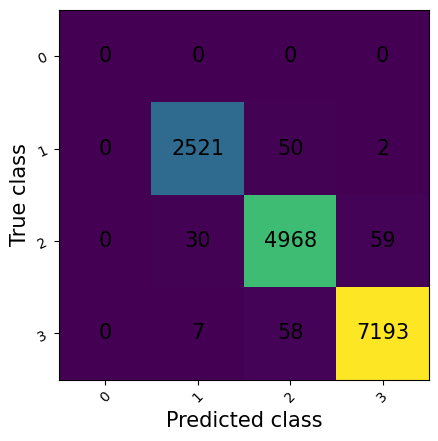

In [24]:
print(f"Overall Accuracy: {mca.compute()}")
print(f"Class Accuracy: {mca_class.compute()}")
print(f"Dice Score: {dice.compute()}")
# print(f"AUROC Score: {auroc.compute}")
print(f"F1 Score: {f1.compute()}")
print(f"Confusion Matrix: {cm.compute()}")

fig, ax = cm.plot()

[[2521   50    2]
 [  30 4968   59]
 [   7   58 7193]]


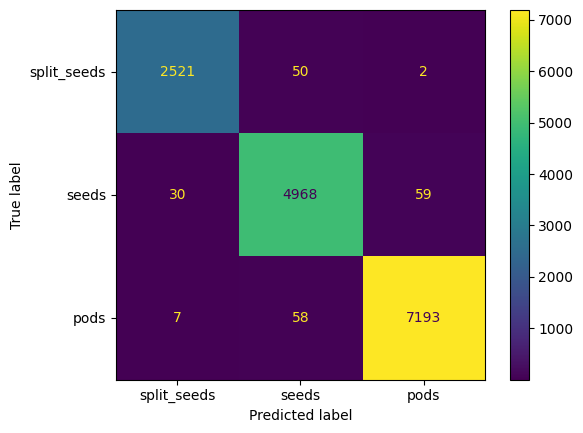

In [43]:
x = cm.compute().cpu().numpy()[1:, 1:]
print(x)

cm_plot = ConfusionMatrixDisplay(x, display_labels=['split_seeds', 'seeds', 'pods'])
cm_plot.plot()

# plt.show()
fig = cm_plot.figure_
plt.savefig('confusion_matrix.png')